In [1]:
from datetime import datetime
import json
import os
import requests
from tqdm.auto import tqdm
from typing import List

from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd

api_functions = {
    "income":"INCOME_STATEMENT",
    "balance":"BALANCE_SHEET",
    "cash":"CASH_FLOW"
}

## 1. Data Preprocessing

Run this cell once to pull MSFT data from alphavantage:

In [153]:
for key in api_functions:
    api_url = f"https://www.alphavantage.co/query?function={api_functions[key]}&symbol=MSFT&apikey=F3MHOGTLZUTFMLWB"
    response = requests.get(api_url)
    with open(f"data\\raw\MSFT_{key}.json","w") as f:
        json.dump(response.json(),f)

# https://www.quora.com/What-are-some-good-free-APIs-for-financial-statements-quarterly-and-or-yearly-on-companies

In [2]:
msft_prices_path = "data/MSFT.csv"
msft_prices = pd.read_csv(msft_prices_path,parse_dates=["Date"],index_col=["Date"])
msft_prices = msft_prices.reindex(index=msft_prices.index[::-1])
msft_date_range = pd.date_range(start="2019-08-07",end="2024-08-06")
msft_df = pd.DataFrame(index=msft_date_range)
msft_df.index.names = ["Date"]
msft_df = msft_df.merge(msft_prices,how="left",left_index=True,right_index=True)
msft_df.ffill(inplace=True)

statement_types = api_functions.keys()
for statement in statement_types:
    with open(f"data\\raw\MSFT_{statement}.json","r") as f:
        msft_temp_data = json.load(f)
    temp_cols = list(msft_temp_data["quarterlyReports"][0].keys())
    msft_temp = pd.concat([pd.DataFrame(report,index=[0]) for report in msft_temp_data["quarterlyReports"]])
    msft_temp["fiscalDateEnding"] = pd.to_datetime(msft_temp["fiscalDateEnding"])
    msft_temp.set_index(keys="fiscalDateEnding",drop=True,inplace=True)
    msft_df = msft_df.merge(msft_temp,how="left",left_index=True,right_index=True)
msft_df.ffill(inplace=True)
msft_df = msft_df.loc[datetime.strptime("2019-12-31","%Y-%m-%d"):]
msft_df.drop(columns=["reportedCurrency_y","netIncome_y"],inplace=True)
msft_df.rename(columns={"reportedCurrency_x":"reportedCurrency","netIncome_x":"netIncome"},inplace=True)
msft_df.head()
int_cols = ["netIncome","commonStockSharesOutstanding","shortLongTermDebtTotal",\
            "cashAndCashEquivalentsAtCarryingValue","ebit","grossProfit","totalRevenue","operatingCashflow",\
                "totalShareholderEquity","operatingIncome","totalCurrentAssets","inventory","totalCurrentLiabilities",\
                    ]
for col in int_cols:
    msft_df[col] = msft_df[col].astype("int64")

## 2. Feature Generation

### Financial Indicators

In [3]:
"""
(Return signal) Profitability multiples: P/E, EV/EBIT
(Return signal) Profitability: gross margin, net margin, cash flow margin, ROE
(Quality check) Operating efficiency: operating margin
(Risk check) Liquidity: quick ratio
(Risk check) Solvency: D/E ratio
"""
# Profitability
msft_df["Return"] = msft_df["Close"].pct_change()
msft_df["Return"] = msft_df["Return"].fillna(0)
msft_df["EPS"] = msft_df["netIncome"]/msft_df["commonStockSharesOutstanding"]
msft_df["PE_ratio"] = msft_df["Close"]/msft_df["EPS"]
msft_df["enterpriseValue"] = (msft_df["Close"]*msft_df["commonStockSharesOutstanding"])+msft_df["shortLongTermDebtTotal"]-msft_df["cashAndCashEquivalentsAtCarryingValue"]
msft_df["EV_EBIT_ratio"] = msft_df["enterpriseValue"]/msft_df["ebit"]
msft_df["grossMargin"] = msft_df["grossProfit"]/msft_df["totalRevenue"]
msft_df["netMargin"] = msft_df["netIncome"]/msft_df["totalRevenue"]
msft_df["cashFlowMargin"] = msft_df["operatingCashflow"]/msft_df["totalRevenue"]
msft_df["ROE"] = msft_df["netIncome"]/msft_df["totalShareholderEquity"]

# Operating efficiency
msft_df["operatingMargin"] = msft_df["operatingIncome"]/msft_df["totalRevenue"]

# Liquidity
msft_df["quick_ratio"] = (msft_df["totalCurrentAssets"] - msft_df["inventory"])/msft_df["totalCurrentLiabilities"]

# Solvency
msft_df["DE_ratio"] = msft_df["shortLongTermDebtTotal"]/msft_df["totalShareholderEquity"]

### Technical Indicators

In [ ]:
"""
(Trend confirmation) Trend: SMA, (ADX)
(Entry & Exit) Momentum: RSI, (MACD)
(Risk management) Volatility: Bollinger Bands
(Validate trend strength) Volume: OBV
Bonus: Fibonacci retracement levels
"""

In [4]:
# Trend: SMA
for i in [5,15,50]:
    msft_df[f"SMA_{i}"] = msft_df["Close"].transform(lambda x:x.rolling(window=i).mean())

# Momentum: Relative Strength Index (RSI)
msft_df["Diff"] = msft_df["Close"].transform(lambda x: x.diff())
msft_df["Up"] = msft_df["Diff"]
msft_df.loc[(msft_df["Up"]<0), "Up"] = 0
msft_df["Down"] = msft_df["Diff"]
msft_df.loc[(msft_df["Down"]>0), "Down"] = 0 
msft_df["Down"] = abs(msft_df["Down"])
for i in [5,15]:
    msft_df[f"avg_{i}up"] = msft_df["Up"].transform(lambda x: x.rolling(window=i).mean())
    msft_df[f"avg_{i}down"] = msft_df["Down"].transform(lambda x: x.rolling(window=i).mean())
    msft_df[f"RS_{i}"] = msft_df[f"avg_{i}up"] / msft_df[f"avg_{i}down"]
    msft_df[f"RSI_{i}"] = 100 - (100/(1+msft_df[f"RS_{i}"]))
msft_df["RSI_ratio"] = msft_df["RSI_5"]/msft_df["RSI_15"]

# Volatility: Bollinger Bands (based on 15-day averaging)
msft_df["SD_15"] = msft_df["Close"].transform(lambda x:x.rolling(window=15).std())
msft_df["BB_up"] = msft_df["SMA_15"] + (2*msft_df["SD_15"])
msft_df["BB_down"] = msft_df["SMA_15"] - (2*msft_df["SD_15"])

# Volume: On-Balance Volume (OBV)
msft_df["OBV"] = (np.sign(msft_df["Diff"])*msft_df["Volume"]).fillna(0).cumsum()

# Null imputation
msft_df.bfill(inplace=True)

In [5]:
# Null values check
null_cols = []
for c in msft_df.columns:
    if msft_df[c].isnull().values.any():
        null_cols.append(c)
print("Null:",null_cols)

Null: []


### Visualization

In [101]:
"""
Key events:
(18 Jan 2022) Announcement of acquisition of Activision Blizzard
(18 Jan 2023) MSFT layoffs
(23 Jan 2023) MSFT increased OpenAI stake
(26 July 2023) Fed rate decision (hike)
(7 Oct 2023) Israel-Palestine war
(25 Oct 2023) Earnings release
(30 Nov 2023) GOOGL launched antitrust action against MSFT
(30 Jan 2024) Earnings release
(1 Mar 2024) Nadella's stock sale
(14 Mar 2024) MSFT announces expands collab w/ oracle for Oracle@Azure
(18 Mar 2024) MSFT anounces collab w/ NVIDIA to accelerate healthcare & life sciences innovation
(24 Apr 2024) Earnings release
(1 May 2024) Fed rate decision (stay)
(12 Jun 2024) MSFT cash dividend announcement, Fed rate decision (stay)
(3 Jul 2024) MSFT layoff

Analysis considerations/issues:
- Difficult to establish causality: confounding variables - overlapping & unknown events
- Comparing across event types, macro climates, company types
"""

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_single_figure(plot_date_range,plot_cols:List[str],y_label:str,plot_title:str,events:List[List]=[]):
    event_colors = ["b","r"]
    plt.figure(figsize=(6,3))
    for c in plot_cols:
        plt.plot(plot_date_range,msft_df.loc[plot_date_range,c],linewidth=0.5,label=c)
    i = 1
    for event in events:
        plt.axvline(x=datetime.strptime(event[0],"%Y-%m-%d"),color=event_colors[i],linewidth=0.5,label=event[1])
        i -= 1
    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.title(plot_title,y=1.03)
    plt.xticks(rotation=45)
    plt.legend(prop={'size': 6})
    plt.show()

def plot_double_axes_figure(plot_date_range,
                            plot_cols_1:List[str],plot_cols_2:List[str],
                            y_label_1:str,y_label_2:str,plot_title:str, events:List[List]=[]):
    
    event_colors = ["b","r"]
    plot_colors = ['g','c','m']
    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()
    fig.set_figwidth(6)
    fig.set_figheight(3)
    ax1.set_ylabel(y_label_1)
    ax2.set_ylabel(y_label_2)
    i = 0
    lines = []
    for c in plot_cols_1:
        line = ax1.plot(plot_date_range,msft_df.loc[plot_date_range,c],linewidth=0.5,label=c,color=plot_colors[i])
        lines.append(line)
        i += 1
    for c in plot_cols_2:
        line = ax2.plot(plot_date_range,msft_df.loc[plot_date_range,c],linewidth=0.5,label=c,color=plot_colors[i])
        lines.append(line)
        i -= 1
    i = 1
    for event in events:
        plt.axvline(x=datetime.strptime(event[0],"%Y-%m-%d"),color=event_colors[i],linewidth=0.5,label=event[1])
        i -= 1
    
    ax1.set_xlabel('Date')
    ax1.set_xticklabels(ax1.get_xticks(),rotation=45)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax1.set_title(plot_title,y=1.03)
    lines_final = lines[0]
    for l in lines[1:]:
        lines_final += l
    labels = [l.get_label() for l in lines_final]
    ax1.legend(lines_final,labels,prop={'size': 6})
    plt.show()

#### Jan 2022 (15 Jan 2022 - 8 Feb 2022)
Event types: Launch (M&A)
- (18 Jan 2022) Announcement of acquisition of Activision Blizzard
- (24 Jan 2022) Announcement of FedEx collab for logisticsa as a service




In [91]:
temp_date_range = pd.date_range(start="2022-01-15",end="2022-02-08")
temp_events = [["2022-01-18","Activision acq"],["2022-01-24","FedEx collab"]]

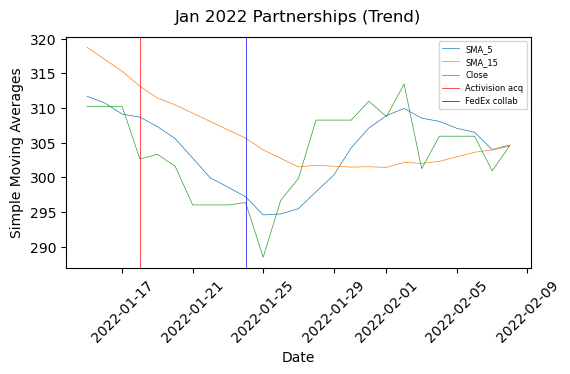

In [92]:

plot_single_figure(plot_date_range=temp_date_range,
            events=temp_events,
            plot_cols=["SMA_5","SMA_15","Close"],
            y_label="Simple Moving Averages",
            plot_title="Jan 2022 Partnerships (Trend)")


C:\Users\yongz\AppData\Local\Temp\ipykernel_24196\4058133203.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(),rotation=45)


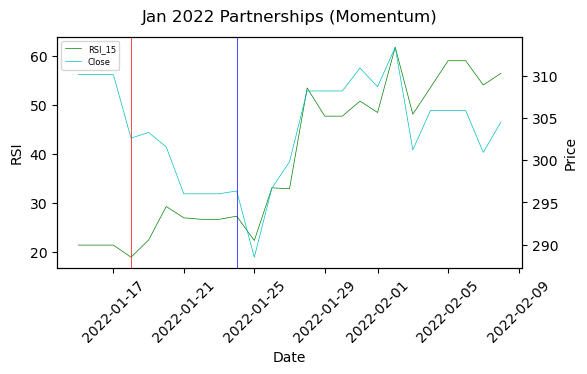

In [93]:
plot_double_axes_figure(plot_date_range=temp_date_range,
            events=temp_events,
            plot_cols_1=["RSI_15"],
            plot_cols_2=["Close"],
            y_label_1="RSI",
            y_label_2="Price",
            plot_title="Jan 2022 Partnerships (Momentum)")

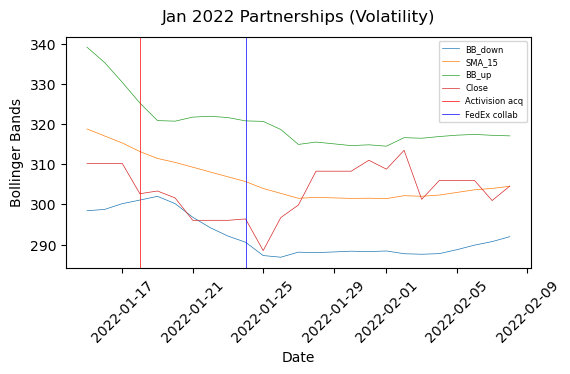

In [94]:
plot_single_figure(plot_date_range=temp_date_range,
            events=temp_events,
            plot_cols=["BB_down","SMA_15","BB_up","Close"],
            y_label="Bollinger Bands",
            plot_title="Jan 2022 Partnerships (Volatility)")

C:\Users\yongz\AppData\Local\Temp\ipykernel_24196\4058133203.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(),rotation=45)


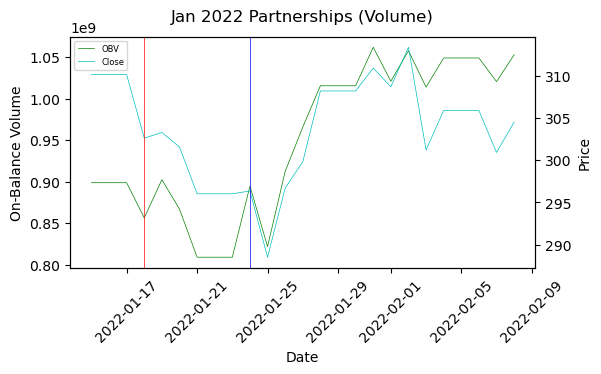

In [95]:
plot_double_axes_figure(plot_date_range=temp_date_range,
            events=temp_events,
            plot_cols_1=["OBV"],
            plot_cols_2=["Close"],
            y_label_1="On-Balance Volume",
            y_label_2="Price",
            plot_title="Jan 2022 Partnerships (Volume)")

#### Jan 2023 (15 Jan 2023 - 8 Feb 2023)
Event types: micro-disaster and launch
- (18 Jan 2023) MSFT layoffs
- (23 Jan 2023) MSFT increased OpenAI stake

In [105]:
temp_date_range_2 = pd.date_range(start="2023-01-01",end="2023-02-08")
# temp_events_2 = [["2023-01-18","MSFT Layoffs"],["2023-01-23","OpenAI Stake"]]
temp_events_2 = [["2023-01-18","MSFT Layoffs"],["2023-01-10","OpenAI Stake"]]

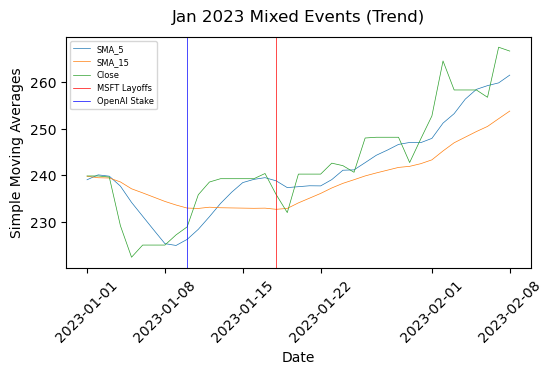

In [106]:

plot_single_figure(plot_date_range=temp_date_range_2,
            events=temp_events_2,
            plot_cols=["SMA_5","SMA_15","Close"],
            y_label="Simple Moving Averages",
            plot_title="Jan 2023 Mixed Events (Trend)")

C:\Users\yongz\AppData\Local\Temp\ipykernel_24196\3265635292.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(),rotation=45)


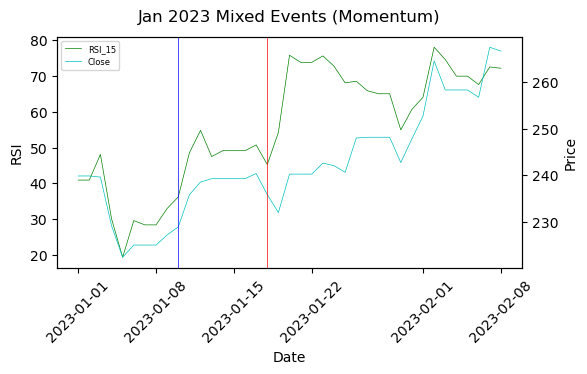

In [107]:
plot_double_axes_figure(plot_date_range=temp_date_range_2,
            events=temp_events_2,
            plot_cols_1=["RSI_15"],
            plot_cols_2=["Close"],
            y_label_1="RSI",
            y_label_2="Price",
            plot_title="Jan 2023 Mixed Events (Momentum)")

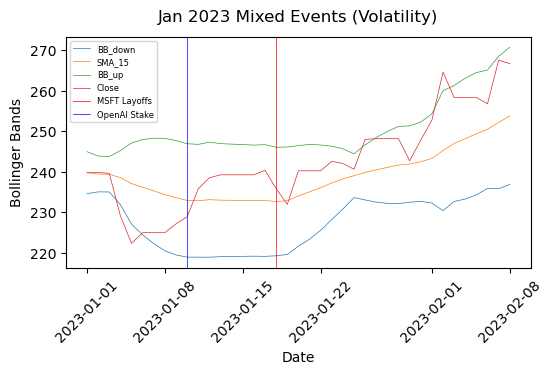

In [108]:
plot_single_figure(plot_date_range=temp_date_range_2,
            events=temp_events_2,
            plot_cols=["BB_down","SMA_15","BB_up","Close"],
            y_label="Bollinger Bands",
            plot_title="Jan 2023 Mixed Events (Volatility)")

C:\Users\yongz\AppData\Local\Temp\ipykernel_24196\3265635292.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(),rotation=45)


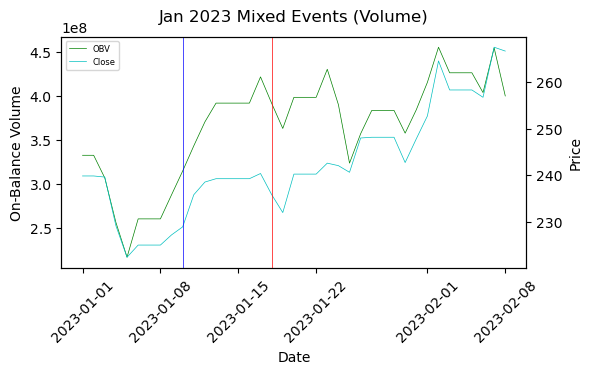

In [109]:
plot_double_axes_figure(plot_date_range=temp_date_range_2,
            events=temp_events_2,
            plot_cols_1=["OBV"],
            plot_cols_2=["Close"],
            y_label_1="On-Balance Volume",
            y_label_2="Price",
            plot_title="Jan 2023 Mixed Events (Volume)")

#### July 2023
Event Type: Macro (Fed rate)
- (26 July 2023) Announcement of Fed rate hike

In [114]:
temp_date_range_3 = pd.date_range(start="2023-07-01",end="2023-08-15")
temp_events_3 = [["2023-07-19","Fed rate hike"]]

C:\Users\yongz\AppData\Local\Temp\ipykernel_24196\3265635292.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(),rotation=45)


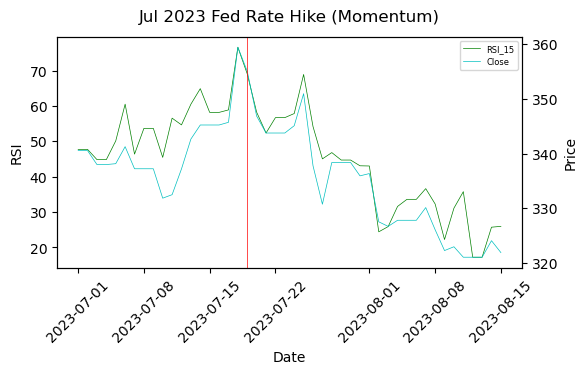

In [115]:
plot_double_axes_figure(plot_date_range=temp_date_range_3,
            events=temp_events_3,
            plot_cols_1=["RSI_15"],
            plot_cols_2=["Close"],
            y_label_1="RSI",
            y_label_2="Price",
            plot_title="Jul 2023 Fed Rate Hike (Momentum)")

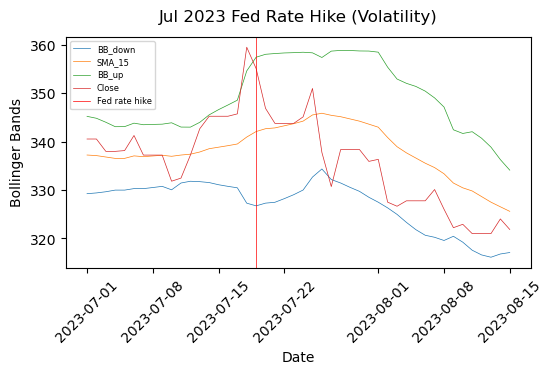

In [116]:
plot_single_figure(plot_date_range=temp_date_range_3,
            events=temp_events_3,
            plot_cols=["BB_down","SMA_15","BB_up","Close"],
            y_label="Bollinger Bands",
            plot_title="Jul 2023 Fed Rate Hike (Volatility)")

C:\Users\yongz\AppData\Local\Temp\ipykernel_24196\3265635292.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(),rotation=45)


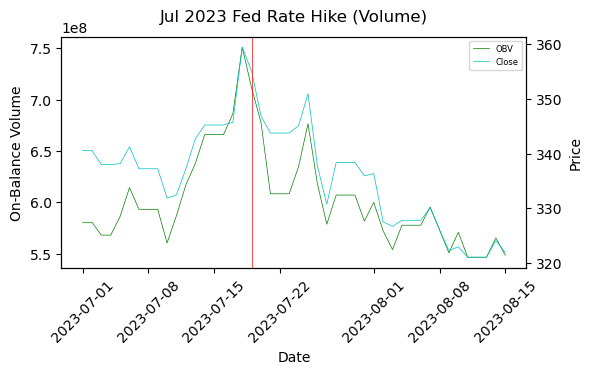

In [117]:
plot_double_axes_figure(plot_date_range=temp_date_range_3,
            events=temp_events_3,
            plot_cols_1=["OBV"],
            plot_cols_2=["Close"],
            y_label_1="On-Balance Volume",
            y_label_2="Price",
            plot_title="Jul 2023 Fed Rate Hike (Volume)")

#### October 2023
Event Type: Macro (Disaster), Earnings Release
- (7 October 2023) Israel-Palestine War
- (25 October 2023) Earnings Release

In [118]:
temp_date_range_4 = pd.date_range(start="2023-10-01",end="2023-11-15")
temp_events_4 = [["2023-10-07","Israel-Palestine"],["2023-10-25","Earnings Release"]]

C:\Users\yongz\AppData\Local\Temp\ipykernel_24196\3265635292.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(),rotation=45)


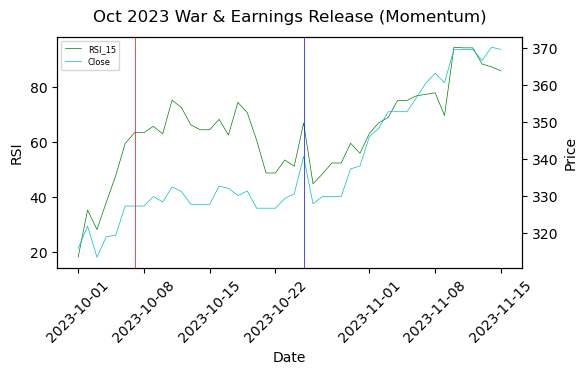

In [119]:
plot_double_axes_figure(plot_date_range=temp_date_range_4,
            events=temp_events_4,
            plot_cols_1=["RSI_15"],
            plot_cols_2=["Close"],
            y_label_1="RSI",
            y_label_2="Price",
            plot_title="Oct 2023 War & Earnings Release (Momentum)")

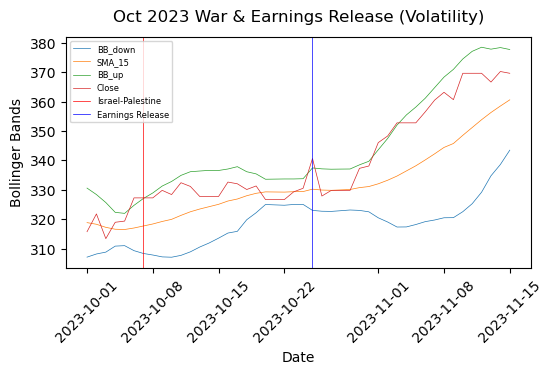

In [120]:
plot_single_figure(plot_date_range=temp_date_range_4,
            events=temp_events_4,
            plot_cols=["BB_down","SMA_15","BB_up","Close"],
            y_label="Bollinger Bands",
            plot_title="Oct 2023 War & Earnings Release (Volatility)")

C:\Users\yongz\AppData\Local\Temp\ipykernel_24196\3265635292.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(),rotation=45)


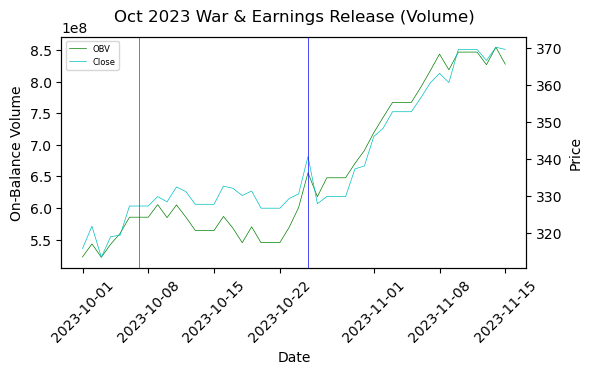

In [121]:
plot_double_axes_figure(plot_date_range=temp_date_range_4,
            events=temp_events_4,
            plot_cols_1=["OBV"],
            plot_cols_2=["Close"],
            y_label_1="On-Balance Volume",
            y_label_2="Price",
            plot_title="Oct 2023 War & Earnings Release (Volume)")

C:\Users\yongz\AppData\Local\Temp\ipykernel_24196\3265635292.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(),rotation=45)


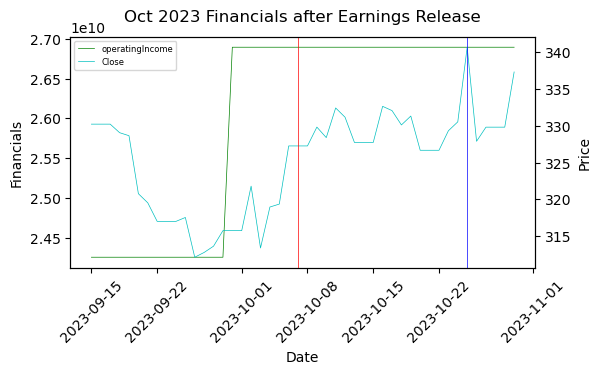

In [136]:
plot_double_axes_figure(plot_date_range=pd.date_range(start="2023-09-15",end="2023-10-30"),
            events=temp_events_4,
            plot_cols_1=["operatingIncome"],
            plot_cols_2=["Close"],
            y_label_1="Financials",
            y_label_2="Price",
            plot_title="Oct 2023 Financials after Earnings Release")

#### Other Analysis

**Technical Analysis**
- Volume

C:\Users\yongz\AppData\Local\Temp\ipykernel_24196\3265635292.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(),rotation=45)


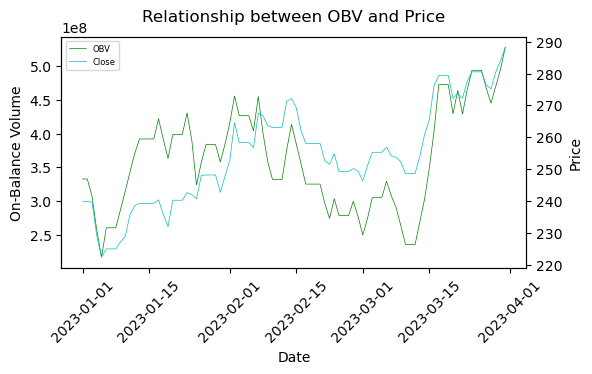

In [104]:
plot_double_axes_figure(plot_date_range=pd.date_range(start="2023-01-01",end="2023-03-31"),
            plot_cols_1=["OBV"],
            plot_cols_2=["Close"],
            y_label_1="On-Balance Volume",
            y_label_2="Price",
            plot_title="Relationship between OBV and Price")

**Financials Analysis**
- EPS

C:\Users\yongz\AppData\Local\Temp\ipykernel_24196\3265635292.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(),rotation=45)


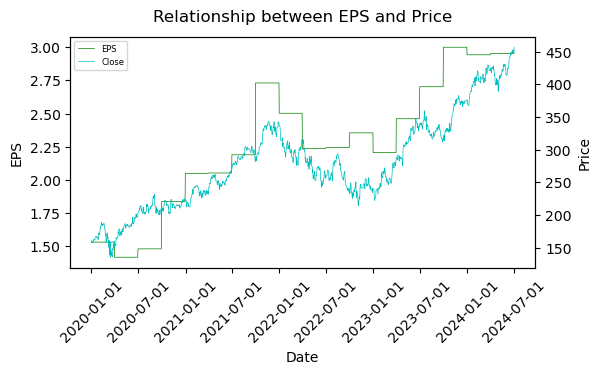

In [127]:
plot_double_axes_figure(plot_date_range=pd.date_range(start="2020-01-01",end="2024-07-01"),
            plot_cols_1=["EPS"],
            plot_cols_2=["Close"],
            y_label_1="EPS",
            y_label_2="Price",
            plot_title="Relationship between EPS and Price")

- ROE

C:\Users\yongz\AppData\Local\Temp\ipykernel_24196\3265635292.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(),rotation=45)


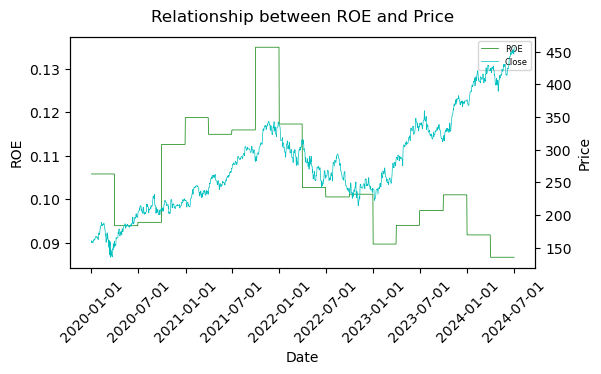

In [132]:
plot_double_axes_figure(plot_date_range=pd.date_range(start="2020-01-01",end="2024-07-01"),
            plot_cols_1=["ROE"],
            plot_cols_2=["Close"],
            y_label_1="ROE",
            y_label_2="Price",
            plot_title="Relationship between ROE and Price")

- Cash Flow Margin

C:\Users\yongz\AppData\Local\Temp\ipykernel_24196\3265635292.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(),rotation=45)


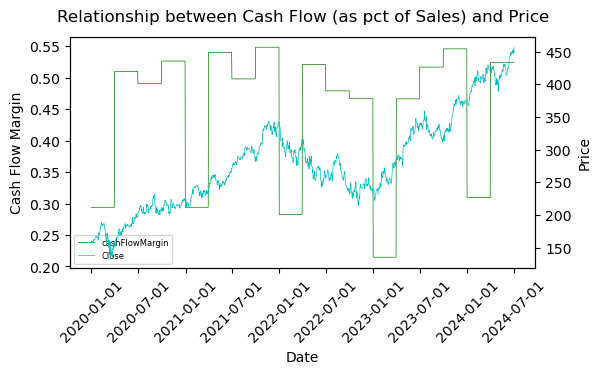

In [133]:
plot_double_axes_figure(plot_date_range=pd.date_range(start="2020-01-01",end="2024-07-01"),
            plot_cols_1=["cashFlowMargin"],
            plot_cols_2=["Close"],
            y_label_1="Cash Flow Margin",
            y_label_2="Price",
            plot_title="Relationship between Cash Flow (as pct of Sales) and Price")

Notes:
- Buy at bottom of RSI

In [168]:
"""
(ok) Generate financial indicators
(ok) Generate technical indicators
(ok) Sample notable events from 2020-2024 (use LLM)
(ok) Visualize event impact
Finalize model logic

Bonus:
Macro data
Industry data
Correlation and regression analysis
New features
EDA for other stocks
"""

'\nGenerate financial indicators\nGenerate technical indicators\nSample notable events from 2020-2024\nVisualize event impact\n\nBonus:\nMacro data\nIndustry data\nCorrelation and regression analysis\nNew features\n'

### Miscellaneous

In [27]:
# Test alpha vantage API
topics = "economy_macro,technology"
time_from = "20240701T0000"
time_to = "20240730T2359"
limit = 200
news_api_url = f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=MSFT&time_from={time_from}&time_to={time_to}&limit={limit}&apikey=F3MHOGTLZUTFMLWB"
response = requests.get(news_api_url)
with open("data/MSFT_news.json","w") as f:
    json.dump(response.json(),f)
with open("data/MSFT_news.json","r") as f:
    msft_news = json.load(f)

In [3]:
# Test Marketaux API
ticker = "MSFT"
date_from = "2020-01-01"
date_to = "2024-07-30"
limit = 200
fmp_api_url = f"https://api.marketaux.com/v1/news/all?symbols={ticker}&published_after={date_from}&published_before={date_to}&api_token=1OkTJ6s1nmfBFI3TbByfguGEQJMTE1MoIKTYgatO"
response = requests.get(fmp_api_url)
with open("data/MSFT_news.json","w") as f:
    json.dump(response.json(),f)
with open("data/MSFT_news.json","r") as f:
    msft_news = json.load(f)

# FMP API free plan doesn't cover news
# Marketaux API free plan only returns up to 3 articles per news requests (<= 100 requests daily)

In [2]:
# Test EODHD API
ticker = "SPY"
date_from = "2020-01-01"
date_to = "2024-07-30"
limit = 200
eod_api_url = f"https://eodhd.com/api/news?s={ticker}&from={date_from}&to={date_to}&limit={limit}&api_token=66b650c82847b1.48897437&fmt=json"
response = requests.get(eod_api_url)
with open(f"data/{ticker}_news.json","w") as f:
    json.dump(response.json(),f)
with open(f"data/{ticker}_news.json","r") as f:
    spy_news = json.load(f)

In [16]:
num = 199
print(msft_news[num]["date"],"\n",msft_news[num]["title"],"\n",msft_news[num]["content"])

2024-07-21T13:30:00+00:00 
 Chips and Taiwan Are a New Cloud for Tech Earnings 
 Security for Taiwan is vital to the chip industry—and to all the tech companies that use those chips

Continue reading


In [19]:
events_str = ""
for i in range(50):
    events_str += "- "+msft_news[i]["title"]+"\n"
with open("data/test_msft_events.txt","w") as f:
    f.write(events_str)

In [5]:
# Check average title length (to gauge feasibility of sending all headlines to an agent for eval)
processed_data_path = "data\processed_data"
files = os.listdir(processed_data_path)
news_csv_filenames = [f for f in files if f[-8:] == "news.csv"]
avg_title_lens = []
for f in tqdm(news_csv_filenames):
    temp_df = pd.read_csv(os.path.join(processed_data_path,f))
    temp_df["tokenized_title"] = temp_df["title"].apply(lambda x:word_tokenize(x))
    temp_df["title_len"] = temp_df["tokenized_title"].apply(lambda x:len(x))
    avg_title_lens.append(temp_df["title_len"].mean())
avg_title_lens

  0%|          | 0/10 [00:00<?, ?it/s]

[23.166666666666668,
 12.838178294573643,
 12.169712793733682,
 12.48704902867715,
 12.386699507389162,
 16.56578947368421,
 12.79136690647482,
 21.227848101265824,
 10.5,
 12.318811881188118]

In [2]:
labelled_df = pd.read_csv("data/processed_data/all_news_labelled_v0.csv")
labelled_df["title"].str.len().max()

263